# Horses or Humans

In [ ]:
import urllib.request
import zipfile

url = "https://storage.googleapis.com/learning-datasets/horse-or-human.zip"
file_name = "horse-or-human.zip"
training_dir = 'horse-or-human/training/'
urllib.request.urlretrieve(url, file_name)

zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

url = "https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip"
file_name = "validation-horse-or-human.zip"
validation_dir = 'horse-or-human/validation/'
urllib.request.urlretrieve(url, file_name)

zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall(validation_dir)
zip_ref.close()

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(
        degrees=0,  # No rotation
        translate=(0.2, 0.2),  # Translate up to 20% vertically and horizontally
        scale=(0.8, 1.2),  # Zoom in or out by 20%
        shear=20,  # Shear by up to 20 degrees
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),


])


# Load the datasets
train_dataset = datasets.ImageFolder(root=training_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=validation_dir, transform=train_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HorsesHumansCNN(nn.Module):
    def __init__(self):
        super(HorsesHumansCNN, self).__init__()
        # Add BatchNorm after each conv layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 18 * 18, 512)
        self.drop = nn.Dropout(0.5)  # Increase dropout rate
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return torch.sigmoid(x)



Epoch 1, Loss: 48.22334289731401
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%


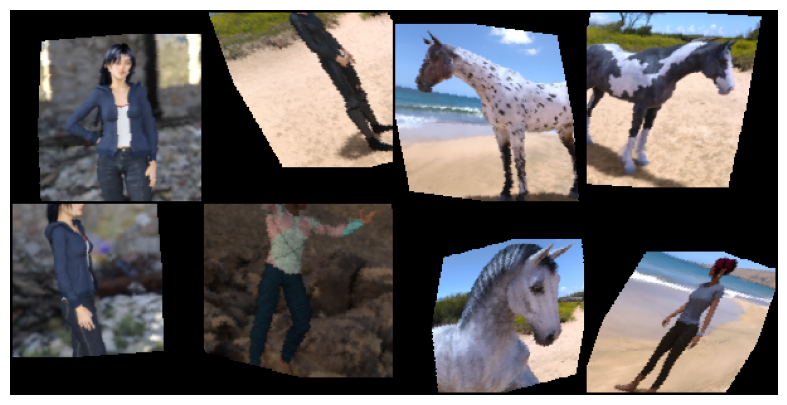

Epoch 2, Loss: 51.63086758237897
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 3, Loss: 51.69840749104818
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 4, Loss: 51.62853922988429
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 5, Loss: 51.69681283199426
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 6, Loss: 49.82648664532286
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%


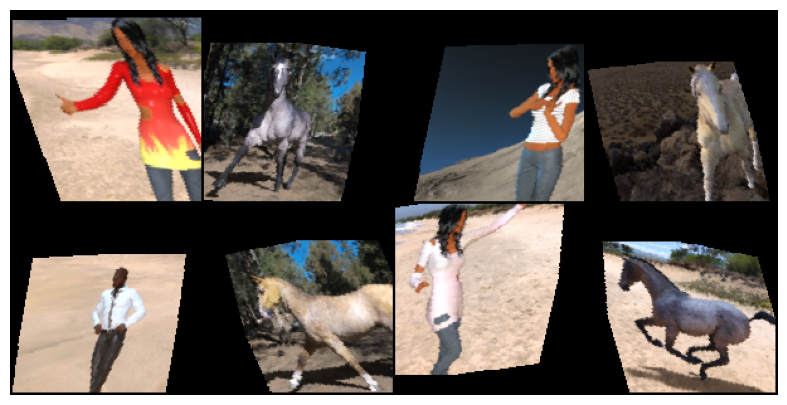

Epoch 7, Loss: 51.680050589821555
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 8, Loss: 51.681782346783265
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 9, Loss: 49.817103992808946
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 10, Loss: 51.652905088482484
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 11, Loss: 50.75850446296461
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%


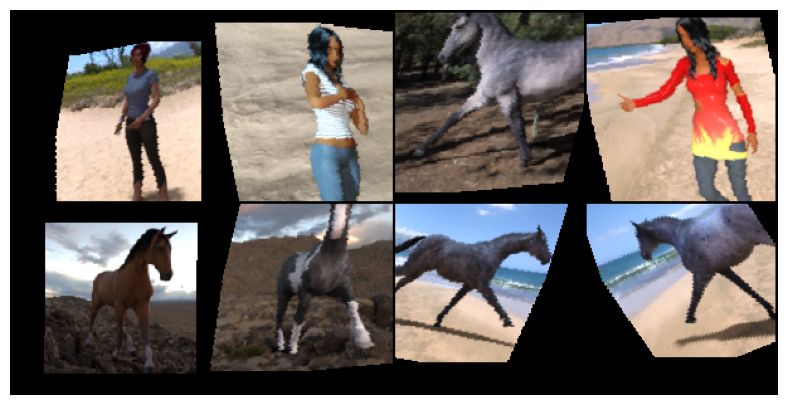

Epoch 12, Loss: 51.708148031523734
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 13, Loss: 51.68220855250503
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 14, Loss: 51.679401860092625
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%
Epoch 15, Loss: 52.58231573393851
Training Set Accuracy: 48.685491723466406%
Validation Set Accuracy: 50.0%


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HorsesHumansCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def show_augmented_batch(dataloader, num_images=8):
    # Get a batch of training data
    images, _ = next(iter(dataloader))

    # Make a grid from batch
    grid = vutils.make_grid(images[:num_images], nrow=4, padding=2, normalize=True)

    # Convert to numpy and transpose
    plt.figure(figsize=(10,5))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.show()


def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()  # Convert labels to float
            optimizer.zero_grad()
            outputs = model(images).view(-1)  # Flatten outputs to match label shape
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

        # Evaluate on training set
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).view(-1)
                predicted = outputs > 0.5  # Threshold predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print(f'Training Set Accuracy: {100 * correct / total}%')

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).view(-1)
                predicted = outputs > 0.5  # Threshold predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print(f'Validation Set Accuracy: {100 * correct / total}%')

        # Usage during training:
        if epoch % 5 == 0:  # Show every 5 epochs
          show_augmented_batch(train_loader)

train_model(15)

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).view(-1)
        predicted = outputs > 0.5  # Threshold predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(outputs)
        print(labels)
    print(f'Validation Accuracy: {100 * correct / total}%')

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 150, 150))  # (Channels, Height, Width)